In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import scipy.stats as stats
import dataframe_image as dfi
from string import Template
from os import listdir
from os.path import isfile, join

# Constants + Helper Function

In [2]:
platforms = ['MOBILE', 'DESKTOP']
PUPPETEER_RESULTS = 'puppeteer_results'
PAGESPEED_RESULTS = 'pagespeed_results'

def get_experiment_results(component_results, component):
    desktop_results = []
    mobile_results = []
    for directory in os.listdir(f'{component_results}/'):
        if directory.endswith('_DESKTOP'):
            postfix_len = len('_DESKTOP')
            website_name = directory[:-postfix_len]
            target_file = f'{directory[:-postfix_len]}_agg.json'
            desktop_results.append((website_name, f'{component_results}/{directory}/{component}/{target_file}'))
        else:
            postfix_len = len('_MOBILE')
            website_name = directory[:-postfix_len]
            target_file = f'{directory[:-postfix_len]}_agg.json'
            mobile_results.append((website_name, f'{component_results}/{directory}/{component}/{target_file}'))
    return desktop_results, mobile_results

In [3]:
puppeteer_desktop_results, puppeteer_mobile_results = get_experiment_results(PUPPETEER_RESULTS, 'puppeteer')
pagespeed_desktop_results, pagespeed_mobile_results = get_experiment_results(PAGESPEED_RESULTS, 'pagespeed')


print(f'Puppeteer Desktop Files {len(puppeteer_desktop_results)}')
print(f'Puppeteer Mobile Files {len(puppeteer_mobile_results)}')
print(puppeteer_desktop_results[0])

print(f'PageSpeed Desktop Files {len(pagespeed_desktop_results)}')
print(f'PageSpeed Mobile Files {len(pagespeed_mobile_results)}')
print(pagespeed_desktop_results[0])

Puppeteer Desktop Files 469
Puppeteer Mobile Files 466
('123moviesfree', 'puppeteer_results/123moviesfree_DESKTOP/puppeteer/123moviesfree_agg.json')
PageSpeed Desktop Files 426
PageSpeed Mobile Files 417
('123moviesfree', 'pagespeed_results/123moviesfree_DESKTOP/pagespeed/123moviesfree_agg.json')


In [4]:
desktop_rows = []
for result_file in puppeteer_desktop_results:
    website_name = result_file[0]
    with open(result_file[1], 'r+') as f:
        data = json.load(f)
        desktop_rows.append({
            'Website' : website_name,
            'Transfer Size(bytes)' : data['transferSizeStats']['value'][0][1],
            'Encoded Transfer Size(bytes)' : data['encodedSizeStats']['value'][0][1],
            'Decoded Transfer Size(bytes)' : data['decodedSizeStats']['value'][0][1],
            'No. of Requests' : round(data['transferredResourcesStats']['value'][0][1])
        })
mobile_rows = []
for result_file in puppeteer_mobile_results:
    website_name = result_file[0]
    with open(result_file[1], 'r+') as f:
        data = json.load(f)
        mobile_rows.append({
            'Website' : website_name,
            'Transfer Size(bytes)(Mobile)' : data['transferSizeStats']['value'][0][1],
            'Encoded Transfer Size(bytes)(Mobile)' : data['encodedSizeStats']['value'][0][1],
            'Decoded Transfer Size(bytes)(Mobile)' : data['decodedSizeStats']['value'][0][1],
            'No. of Requests (Mobile)' : round(data['transferredResourcesStats']['value'][0][1])
        })
puppeteer_desktop_df = pd.DataFrame(desktop_rows)  
puppeteer_mobile_df = pd.DataFrame(mobile_rows)    
puppeteer_df = pd.merge(puppeteer_desktop_df, puppeteer_mobile_df, on='Website')

In [5]:
puppeteer_df.dropna(inplace=True)

for column in puppeteer_df.columns:
    if column != 'Website':
        puppeteer_df[column] = puppeteer_df[column].apply(lambda x: float(x))

indexes = puppeteer_df[puppeteer_df['Encoded Transfer Size(bytes)'] > 30000000].index
puppeteer_df.drop(indexes, inplace=True)
indexes = puppeteer_df[puppeteer_df['Transfer Size(bytes)'] < 1500].index
puppeteer_df.drop(indexes, inplace=True)

indexes = puppeteer_df[puppeteer_df['Encoded Transfer Size(bytes)(Mobile)'] > 30000000].index
puppeteer_df.drop(indexes, inplace=True)

display(puppeteer_df)

,Website,Transfer Size(bytes),Encoded Transfer Size(bytes),Decoded Transfer Size(bytes),No. of Requests,Transfer Size(bytes)(Mobile),Encoded Transfer Size(bytes)(Mobile),Decoded Transfer Size(bytes)(Mobile),No. of Requests (Mobile)
0,123moviesfree,200682.2,197443.8,702705.0,9.0,200747.0,197493.2,702705.0,9.0
1,1337x,438076.6,431860.6,987950.0,20.0,438120.6,431892.0,987950.0,20.0
2,22games,2161819.4,2118839.0,6561695.0,143.0,2180421.0,2137719.0,6606076.8,146.0
3,247hd,858409.6,852600.6,935984.0,16.0,858509.6,852598.8,935984.0,16.0
5,4channel,27607.0,26007.4,71477.8,17.0,27667.8,26064.6,71538.6,17.0
...,...,...,...,...,...,...,...,...,...
460,yr,531863.0,519000.8,1676556.0,56.0,744582.4,731600.2,1889327.2,55.0
461,yts,848103.0,836301.0,1521954.0,44.0,860745.6,849009.0,1557256.6,44.0
462,zara,702297.2,689078.8,2870429.8,33.0,809065.2,793330.4,3049960.6,36.0
464,zhihu,859506.6,852770.0,2230545.6,19.0,1124538.0,1115175.6,3698150.2,26.0


In [6]:
desktop_rows = []
for result_file in pagespeed_desktop_results:
    website_name = result_file[0]
    with open(result_file[1], 'r+') as f:
        data = json.load(f)
        desktop_rows.append({
            'Website' : website_name,
            'Performance' : data['performance']['value'][0][1],
            'SEO' : data['seo']['value'][0][1],
            'TTI' : data['timeToInteractive']['value'][0][1]
            
        })
mobile_rows = []
for result_file in pagespeed_mobile_results:
    website_name = result_file[0]
    with open(result_file[1], 'r+') as f:
        data = json.load(f)
        mobile_rows.append({
            'Website' : website_name,
            'Performance (Mobile)' : data['performance']['value'][0][1],
            'SEO (Mobile)' : data['seo']['value'][0][1],
            'TTI (Mobile)' : data['timeToInteractive']['value'][0][1]
        })
pagespeed_desktop_df = pd.DataFrame(desktop_rows)  
pagespeed_mobile_df = pd.DataFrame(mobile_rows)    
pagespeed_df = pd.merge(pagespeed_desktop_df, pagespeed_mobile_df, on='Website')

In [7]:
df = pd.merge(pagespeed_df, puppeteer_df, on='Website')
df.dropna(inplace=True)
df['Performance'] = df['Performance'].apply(lambda x: float(x))
df['Performance (Mobile)'] = df['Performance (Mobile)'].apply(lambda x: float(x))
display(df)

,Website,Performance,SEO,TTI,Performance (Mobile),SEO (Mobile),TTI (Mobile),Transfer Size(bytes),Encoded Transfer Size(bytes),Decoded Transfer Size(bytes),No. of Requests,Transfer Size(bytes)(Mobile),Encoded Transfer Size(bytes)(Mobile),Decoded Transfer Size(bytes)(Mobile),No. of Requests (Mobile)
0,123moviesfree,1.000,0.80,578.0,0.974,0.83,3117.9,200682.2,197443.8,702705.0,9.0,200747.0,197493.2,702705.0,9.0
1,1337x,0.964,1.00,1141.6,0.864,0.99,4588.0,438076.6,431860.6,987950.0,20.0,438120.6,431892.0,987950.0,20.0
2,4channel,0.992,1.00,591.4,0.938,0.94,2293.0,27607.0,26007.4,71477.8,17.0,27667.8,26064.6,71538.6,17.0
3,4chan,0.988,1.00,660.8,0.904,0.94,3295.0,37415.2,35277.4,95444.6,18.0,37422.8,35267.0,95458.6,18.0
4,8muses,0.840,0.83,1939.0,0.550,0.86,7001.4,804770.6,789589.0,1207850.8,46.0,414668.4,403340.0,827501.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,youtube,0.222,0.75,5874.0,0.314,0.92,10155.4,3035060.0,3026659.4,9728175.2,68.0,905566.4,901803.2,2667833.0,24.0
360,yr,0.886,1.00,1555.0,0.454,1.00,7941.6,531863.0,519000.8,1676556.0,56.0,744582.4,731600.2,1889327.2,55.0
361,yts,0.928,0.73,969.3,0.632,0.75,6993.7,848103.0,836301.0,1521954.0,44.0,860745.6,849009.0,1557256.6,44.0
362,zara,0.742,0.83,2426.2,0.150,0.86,11390.3,702297.2,689078.8,2870429.8,33.0,809065.2,793330.4,3049960.6,36.0


In [8]:
df['Compression Rate(%)'] = df['Encoded Transfer Size(bytes)'] / df['Decoded Transfer Size(bytes)']
df['Compression Rate(%)']  = df['Compression Rate(%)'].apply(lambda x: round(1 - x, 4))

df['Compression Rate(%) (Mobile)'] = df['Encoded Transfer Size(bytes)(Mobile)'] / df['Decoded Transfer Size(bytes)(Mobile)']
df['Compression Rate(%) (Mobile)']  = df['Compression Rate(%) (Mobile)'].apply(lambda x: round(1 - x, 4))

display(df)

,Website,Performance,SEO,TTI,Performance (Mobile),SEO (Mobile),TTI (Mobile),Transfer Size(bytes),Encoded Transfer Size(bytes),Decoded Transfer Size(bytes),No. of Requests,Transfer Size(bytes)(Mobile),Encoded Transfer Size(bytes)(Mobile),Decoded Transfer Size(bytes)(Mobile),No. of Requests (Mobile),Compression Rate(%),Compression Rate(%) (Mobile)
0,123moviesfree,1.000,0.80,578.0,0.974,0.83,3117.9,200682.2,197443.8,702705.0,9.0,200747.0,197493.2,702705.0,9.0,0.7190,0.7190
1,1337x,0.964,1.00,1141.6,0.864,0.99,4588.0,438076.6,431860.6,987950.0,20.0,438120.6,431892.0,987950.0,20.0,0.5629,0.5628
2,4channel,0.992,1.00,591.4,0.938,0.94,2293.0,27607.0,26007.4,71477.8,17.0,27667.8,26064.6,71538.6,17.0,0.6361,0.6357
3,4chan,0.988,1.00,660.8,0.904,0.94,3295.0,37415.2,35277.4,95444.6,18.0,37422.8,35267.0,95458.6,18.0,0.6304,0.6306
4,8muses,0.840,0.83,1939.0,0.550,0.86,7001.4,804770.6,789589.0,1207850.8,46.0,414668.4,403340.0,827501.0,35.0,0.3463,0.5126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,youtube,0.222,0.75,5874.0,0.314,0.92,10155.4,3035060.0,3026659.4,9728175.2,68.0,905566.4,901803.2,2667833.0,24.0,0.6889,0.6620
360,yr,0.886,1.00,1555.0,0.454,1.00,7941.6,531863.0,519000.8,1676556.0,56.0,744582.4,731600.2,1889327.2,55.0,0.6904,0.6128
361,yts,0.928,0.73,969.3,0.632,0.75,6993.7,848103.0,836301.0,1521954.0,44.0,860745.6,849009.0,1557256.6,44.0,0.4505,0.4548
362,zara,0.742,0.83,2426.2,0.150,0.86,11390.3,702297.2,689078.8,2870429.8,33.0,809065.2,793330.4,3049960.6,36.0,0.7599,0.7399


In [9]:

display(df[df['Transfer Size(bytes)'] > 2e+7])

,Website,Performance,SEO,TTI,Performance (Mobile),SEO (Mobile),TTI (Mobile),Transfer Size(bytes),Encoded Transfer Size(bytes),Decoded Transfer Size(bytes),No. of Requests,Transfer Size(bytes)(Mobile),Encoded Transfer Size(bytes)(Mobile),Decoded Transfer Size(bytes)(Mobile),No. of Requests (Mobile),Compression Rate(%),Compression Rate(%) (Mobile)
262,ruck,0.182,0.83,14822.4,0.06,0.75,77600.8,22403037.8,22333718.2,25279116.0,156.0,22419251.0,22350869.0,25315631.0,156.0,0.1165,0.1171


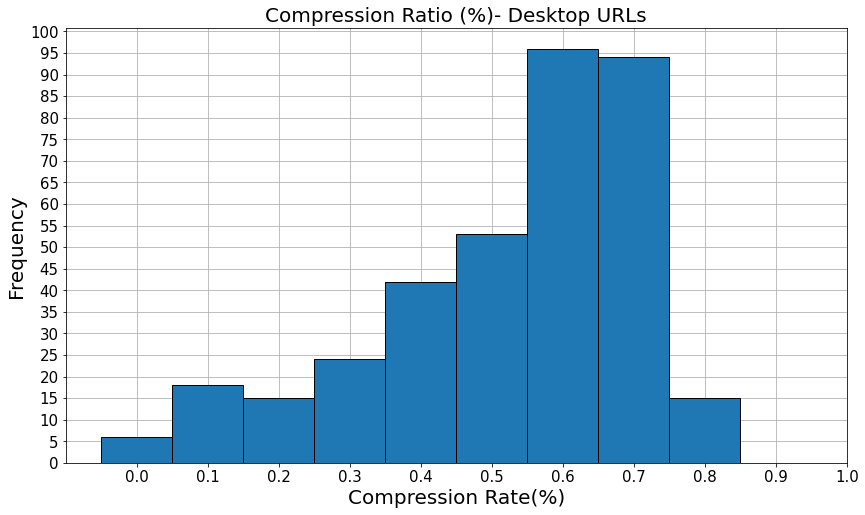

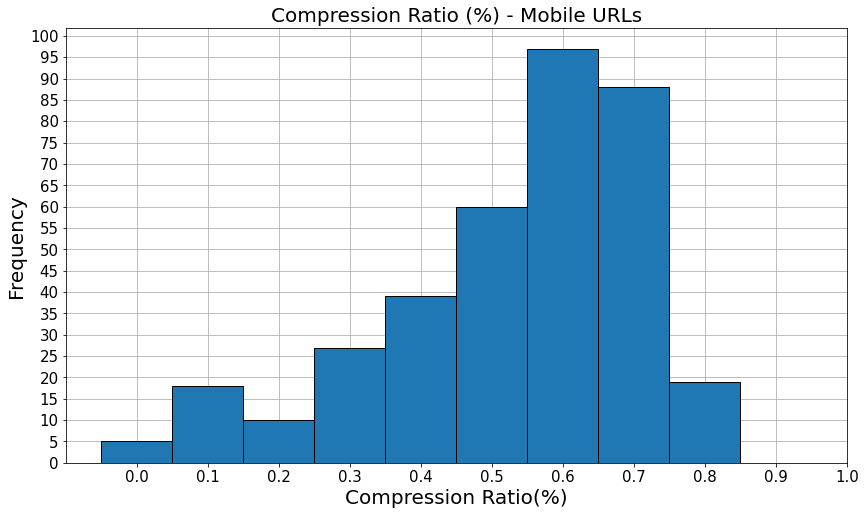

In [10]:
# display(df[df['Compression Rate(%) (Mobile)'] < 0])
fig, ax = plt.subplots(figsize=(14, 8))
bins = np.arange(0, 1.1, 0.1) - 0.05
plt.title('Compression Ratio (%)- Desktop URLs',fontsize=20)
plt.grid(zorder=0)
plt.xticks([x for x in np.arange(0, 1.1, 0.1)], fontsize=15)
plt.xlabel('Compression Rate(%)', fontsize=20)
plt.xlim(-0.1,1.0)
y, x, _ =plt.hist(df['Compression Rate(%)'], bins, edgecolor='black', zorder=3)
plt.yticks([y for y in np.arange(0, max(y)+5, 5)], fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('plots/compression_desktop_histogram.jpg')
plt.show()


fig, ax = plt.subplots(figsize=(14, 8))
bins = np.arange(0, 1.1, 0.1) - 0.05
plt.title('Compression Ratio (%) - Mobile URLs',fontsize=20)
plt.xticks([x for x in np.arange(0, 1.1, 0.1)], fontsize=15)
plt.xlabel('Compression Ratio(%)', fontsize=20)
plt.xlim(-0.1, 1.0)

plt.grid(zorder=0)
y, x, _ = plt.hist(df['Compression Rate(%) (Mobile)'], bins,edgecolor='black', zorder=3)
plt.yticks([y for y in np.arange(0, max(y)+5, 5)], fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('plots/compression_mobile_histogram.jpg')
plt.show()

In [11]:
print(df['Compression Rate(%)'].mean())
print(df['Transfer Size(bytes)'].mean()/1e+3)
print(df['Transfer Size(bytes)'].median()/1e+3)
print()
print(df['Compression Rate(%) (Mobile)'].mean())
print(df['Transfer Size(bytes)(Mobile)'].mean()/1e+6)
print(df['Transfer Size(bytes)(Mobile)'].median()/1e+3)


0.5267052341597797
1786.7055520661152
1189.4114

0.5307859504132231
1.7018311272727273
1163.3642


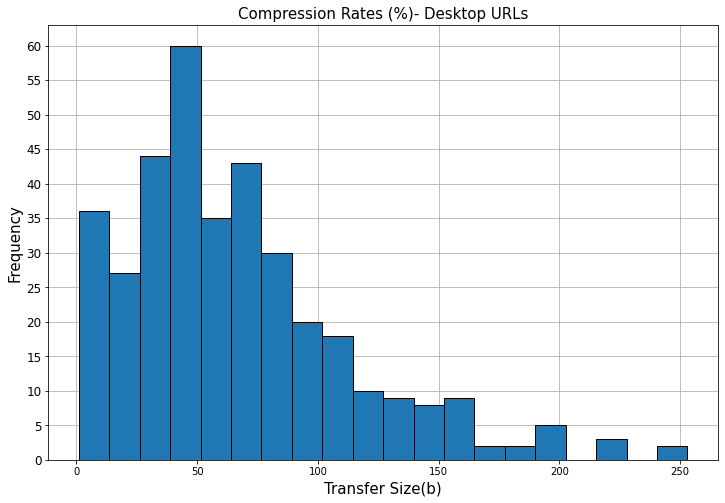

In [12]:
# # display(df[df['Compression Rate(%) (Mobile)'] < 0])
# fig, ax = plt.subplots(figsize=(12, 8))
# # bins = np.arange(0, 1.1, 0.1) - 0.05
# plt.title('Compression Rates (%)- Desktop URLs',fontsize=15)
# plt.grid(zorder=0)
# # plt.xticks([x for x in np.arange(0, 1.1, 0.1)], fontsize=12)
# plt.xlabel('Transfer Size(b)', fontsize=15)
# # plt.xlim(-0.1,1.0)
# y, x, _ = plt.hist(df['Transfer Size(bytes)'], bins=20, edgecolor='black', zorder=3)
# plt.yticks([y for y in np.arange(0, max(y)+5, 5)], fontsize=12)
# plt.ylabel('Frequency', fontsize=15)
# # plt.savefig('plots/compression_desktop_histogram.jpg')
# plt.show()

# display(df[df['Compression Rate(%) (Mobile)'] < 0])
fig, ax = plt.subplots(figsize=(12, 8))
# bins = np.arange(0, 1.1, 0.1) - 0.05
plt.title('Compression Rates (%)- Desktop URLs',fontsize=15)
plt.grid(zorder=0)
# plt.xticks([x for x in np.arange(0, 1.1, 0.1)], fontsize=12)
plt.xlabel('Transfer Size(b)', fontsize=15)
# plt.xlim(-0.1,1.0)
y, x, _ = plt.hist(df['No. of Requests'], bins=20, edgecolor='black', zorder=3)
plt.yticks([y for y in np.arange(0, max(y)+5, 5)], fontsize=12)
plt.ylabel('Frequency', fontsize=15)
# plt.savefig('plots/compression_desktop_histogram.jpg')
plt.show()

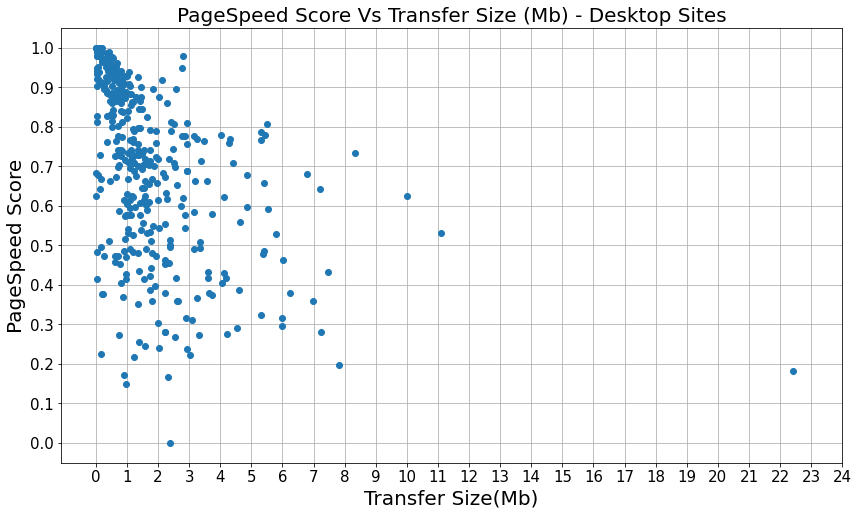

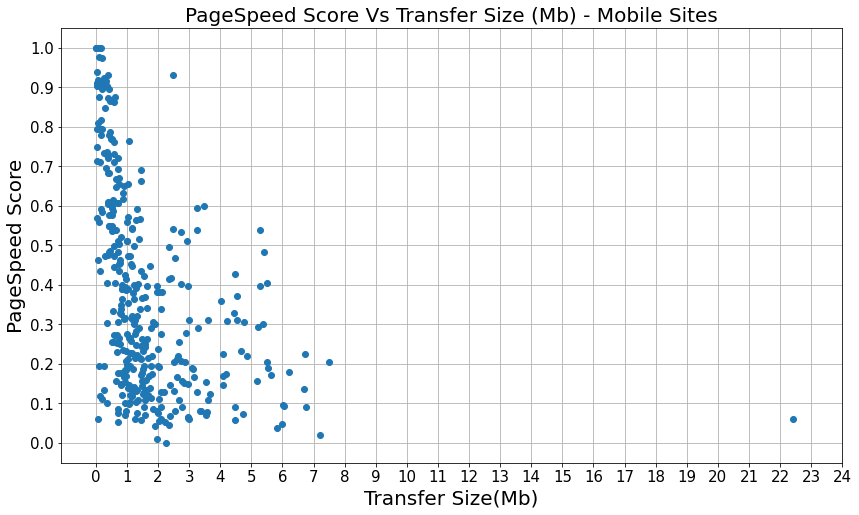

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.grid(zorder=0)
plt.title('PageSpeed Score Vs Transfer Size (Mb) - Desktop Sites', fontsize=20)

x_vals = df['Transfer Size(bytes)'].apply(lambda x : x / 1e+6)
plt.scatter(x_vals, df['Performance'], zorder=3)
plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=15)
plt.xlabel('Transfer Size(Mb)',fontsize=20)
plt.yticks([y for y in np.arange(0,1.1, 0.1)],fontsize=15)
plt.ylabel('PageSpeed Score', fontsize=20)
plt.savefig('plots/pagespeed_vs_transfer_size_desktop.jpg')
plt.show()

fig, ax = plt.subplots(figsize=(14, 8))
plt.grid(zorder=0)
plt.title('PageSpeed Score Vs Transfer Size (Mb) - Mobile Sites', fontsize=20)
x_vals = df['Transfer Size(bytes)(Mobile)'].apply(lambda x : x / 1e+6)

plt.scatter(x_vals, df['Performance (Mobile)'], zorder=3)
plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=15)
plt.xlabel('Transfer Size(Mb)',fontsize=20)
plt.yticks([y for y in np.arange(0,1.1, 0.1)],fontsize=15)
plt.ylabel('PageSpeed Score', fontsize=20)
plt.savefig('plots/pagespeed_vs_transfer_size_mobile.jpg')
plt.show()

In [12]:
pagespeed_score = df['Performance']
transfer_size = df['Transfer Size(bytes)']

print(f'Kendall = {pagespeed_score.corr(transfer_size, method="kendall")}')
print(f'Spearman = {pagespeed_score.corr(transfer_size, method="spearman")}')
print(f'Pearson  = {pagespeed_score.corr(transfer_size, method="pearson")}')

print()
pagespeed_score_mobile = df['Performance (Mobile)']
transfer_size_mobile = df['Transfer Size(bytes)(Mobile)']

print(f'Kendall = {pagespeed_score_mobile.corr(transfer_size_mobile, method="kendall")}')
print(f'Spearman = {pagespeed_score_mobile.corr(transfer_size_mobile, method="spearman")}')
print(f'Pearson  = {pagespeed_score_mobile.corr(transfer_size_mobile, method="pearson")}')

Kendall = -0.4113338457334263
Spearman = -0.5664404543461959
Pearson  = -0.42559239775554586

Kendall = -0.4161888706976553
Spearman = -0.5765818270437335
Pearson  = -0.4035183505029521


In [20]:
display(df[df['TTI (Mobile)'] > 10000])

,Website,Performance,SEO,TTI,Performance (Mobile),SEO (Mobile),TTI (Mobile),Transfer Size(bytes),Encoded Transfer Size(bytes),Decoded Transfer Size(bytes),Transfer Size(bytes)(Mobile),Encoded Transfer Size(bytes)(Mobile),Decoded Transfer Size(bytes)(Mobile),Compression Rate(%),Compression Rate(%) (Mobile)
5,9anime,0.876,0.91,2195.8,0.350,0.88,12262.3,791408.6,779001.4,2200878.4,791551.4,779327.0,2201598.0,0.6460,0.6460
7,accaglobal,0.876,0.82,2003.5,0.284,0.85,12956.1,1280866.6,1251400.4,3426700.4,1275019.8,1245604.8,3427259.0,0.6348,0.6366
8,accesscu,0.614,0.82,2858.8,0.306,0.85,11619.6,2000063.4,1961141.4,2565126.0,1835308.4,1797475.0,2534004.0,0.2355,0.2907
12,aib,0.544,0.82,5348.2,0.204,0.81,23234.7,2875944.8,2844940.2,4571733.0,2870685.8,2839707.8,4550832.0,0.3777,0.3760
13,airbnb,0.578,1.00,4091.2,0.234,1.00,16213.5,1135559.4,1070851.6,4991031.0,968781.2,919974.4,3987784.8,0.7854,0.7693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,yahoo,0.728,0.75,5299.6,0.464,0.93,10585.8,119917.2,117268.2,292429.0,72310.2,69492.6,249001.0,0.5990,0.7209
357,ycharts,0.918,0.82,1239.2,0.468,0.85,10240.0,2114914.4,2083161.4,2601838.2,2551227.0,2519970.2,3039904.0,0.1994,0.1710
359,youtube,0.222,0.75,5874.0,0.314,0.92,10155.4,3035060.0,3026659.4,9728175.2,905566.4,901803.2,2667833.0,0.6889,0.6620
362,zara,0.742,0.83,2426.2,0.150,0.86,11390.3,702297.2,689078.8,2870429.8,809065.2,793330.4,3049960.6,0.7599,0.7399


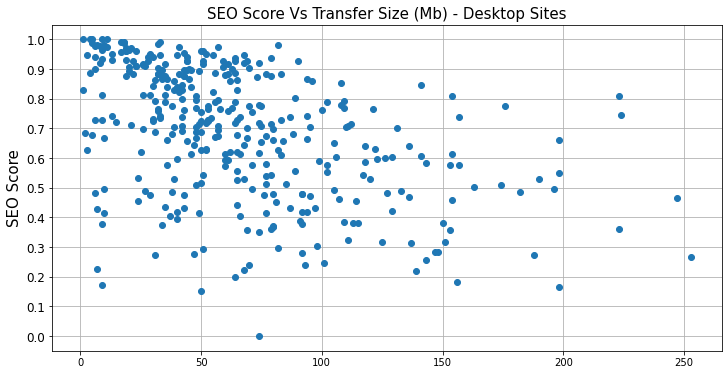

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(zorder=0)
plt.title('SEO Score Vs Transfer Size (Mb) - Desktop Sites', fontsize=15)

x_vals = df['No. of Requests']
plt.scatter(x_vals, df['Performance'], zorder=3)
# plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=12)
# plt.xlabel('Transfer Size(Mb)',fontsize=15)
plt.yticks([y for y in np.arange(0,1.1, 0.1)],fontsize=12)
plt.ylabel('SEO Score', fontsize=15)
# plt.savefig('plots/seo_vs_transfer_size_desktop.jpg')
plt.show()

# fig, ax = plt.subplots(figsize=(12, 6))
# plt.grid(zorder=0)
# plt.title('SEO Score Vs Transfer Size (Mb) - Mobile Sites', fontsize=15)
# x_vals = df['Transfer Size(bytes)(Mobile)'].apply(lambda x : x / 1e+6)

# plt.scatter(x_vals, df['SEO (Mobile)'], zorder=3)
# plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=12)
# plt.xlabel('Transfer Size(Mb)',fontsize=15)
# plt.yticks([y for y in np.arange(0,1.1, 0.1)],fontsize=12)
# plt.ylabel('SEO Score', fontsize=15)
# # plt.savefig('plots/seo_vs_transfer_size_mobile.jpg')
# plt.show()

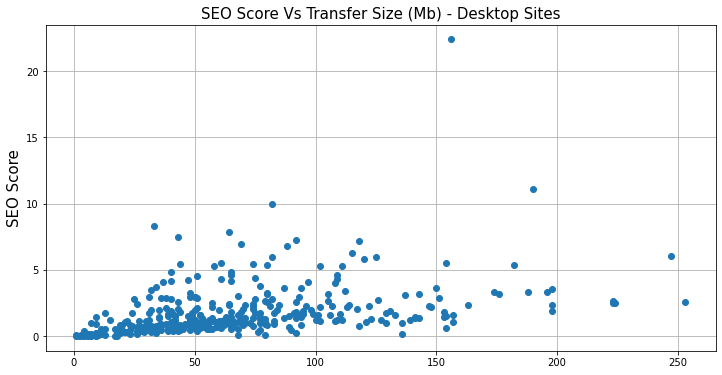

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(zorder=0)
plt.title('SEO Score Vs Transfer Size (Mb) - Desktop Sites', fontsize=15)

x_vals = df['No. of Requests']
plt.scatter(x_vals, df['Transfer Size(bytes)'].apply(lambda x : x / 1e+6), zorder=3)
# plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=12)
# plt.xlabel('Transfer Size(Mb)',fontsize=15)
# plt.yticks([y for y in np.arange(0,1.1, 0.1)],fontsize=12)
plt.ylabel('SEO Score', fontsize=15)
# plt.savefig('plots/seo_vs_transfer_size_desktop.jpg')
plt.show()

In [43]:
tti = df['Performance']
transfer_size = df['No. of Requests']

print(f'Kendall = {tti.corr(transfer_size, method="kendall")}')
print(f'Spearman = {tti.corr(transfer_size, method="spearman")}')
print(f'Pearson  = {tti.corr(transfer_size, method="pearson")}')

print()
# tti_mobile = df['Best Practices (Mobile)']
# transfer_size_mobile = df['Transfer Size(bytes)(Mobile)']

# print(f'Kendall = {tti_mobile.corr(transfer_size_mobile, method="kendall")}')
# print(f'Spearman = {tti_mobile.corr(transfer_size_mobile, method="spearman")}')
# print(f'Pearson  = {tti_mobile.corr(transfer_size_mobile, method="pearson")}')

Kendall = -0.36192042047580836
Spearman = -0.5042290154954367
Pearson  = -0.4577836847074982



In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(zorder=0)
plt.title('Time To Interactive(ms) Vs Transfer Size (Mb) - Desktop Sites', fontsize=15)

x_vals = df['Transfer Size(bytes)'].apply(lambda x : x / 1e+6)
plt.scatter(x_vals, df['TTI'], zorder=3)
plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=12)
plt.xlabel('Transfer Size(Mb)',fontsize=15)
max_y = max(df['TTI'])
plt.yticks([y for y in np.arange(0, max_y+5000, 1000)])
plt.ylabel('First Contenful Paint(ms)', fontsize=15)
plt.savefig('plots/tti_vs_transfer_size_desktop.jpg')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(zorder=0)
plt.title('Time To Interactive(ms) Vs Transfer Size (Mb) - Mobile Sites', fontsize=15)
x_vals = df['Transfer Size(bytes)(Mobile)'].apply(lambda x : x / 1e+6)

plt.scatter(x_vals, df['TTI (Mobile)'], zorder=3)
plt.xticks([x for x in np.arange(0, max(x_vals) + 2, 1)], fontsize=12)
plt.xlabel('Transfer Size(Mb)',fontsize=15)
max_y = max(df['TTI (Mobile)'])
plt.yticks([y for y in np.arange(0, max_y+5000, 5000)])

# plt.yticks([y for y in np.arange(0,max(df['TTI (Mobile)'] + 10000))],fontsize=12)
plt.ylabel('Time To Interactive(ms)', fontsize=15)
plt.savefig('plots/tti_vs_transfer_size_mobi